# Front page heatmap

If we view the front page of each newspaper as an MxN matrix, we can assign each pixel an intensity P based off the font size of the character at that location. Averaging the intensity across all newspapers will generate the "average importance" of a particular location on a front page for all newspapers of that size.

* We'll first group newspapers into particular sizes
* We'll smooth the output using a density-based heatmap

In [1]:
import pandas as pd

df = pd.read_sql_table('frontpage_texts', 'postgres:///frontpages')

In [2]:
df.head()

,text,fontface,fontsize,bbox_left,bbox_bottom,bbox_right,bbox_top,bbox_area,avg_character_area,percent_of_page,page,page_width,page_height,page_area,date,day_of_week,weekend,slug,id
0,"See SAFETY, 2A\n",HHDPCE+HelveticaNeueLTStd-BdCn,10.665,674.70,916.106,729.999,926.771,589.763835,45.072767,0.000536,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190349
1,"CU, CORA\ndisagree\non records\n",HHDPOJ+CenturyStd-BoldCondensed,38.346,594.00,802.122,727.795,904.488,13696.058970,591.161109,0.012439,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190350
2,By Elizabeth Hernandez\nStaff Writer\n,HHDPCA+HelveticaNeueLTStd-Bd,10.140,594.00,779.035,689.477,799.180,1923.384165,42.899610,0.001747,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190351
3,Proponents of a bill intended to\nmake Colorad...,HHDPOD+CenturyOldStyleStd-Regular,11.932,594.00,532.381,730.055,775.305,33051.024820,52.021359,0.030018,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190352
4,"See OPEN RECORDS, 11A\n",HHDPCE+HelveticaNeueLTStd-BdCn,10.665,642.31,519.376,729.997,530.041,935.181855,48.019037,0.000849,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190353


First, let's discover how many unique layouts there are for newspapers, and whether there is only one size per newspaper.

In [3]:
len(df.groupby(['page_width', 'page_height']).indices)

354

There may be subtle pixel-level differences that may be ignored. Let's round all values to the nearest pixel.

In [4]:
df['page_width_round'] = df['page_width'].apply(int)
df['page_height_round'] = df['page_height'].apply(int)

len(df.groupby(['page_width_round', 'page_height_round']).indices)

333

To the nearest 10 pixels?

In [5]:
df['page_width_round_10'] = df['page_width'].apply(lambda w: int(w/10)*10)
df['page_height_round_10'] = df['page_height'].apply(lambda w: int(w/10)*10)

print('''Number of unique dimensions: {}

Top dimensions:
{}'''.format(
    len(df.groupby(['page_width_round_10', 'page_height_round_10']).slug.nunique()),
    df.groupby(['page_width_round_10', 'page_height_round_10']).slug.nunique().sort_values(ascending=False)[:10]
))

Number of unique dimensions: 270

Top dimensions:
page_width_round_10  page_height_round_10
790                  1580                    36
                     1510                    30
                     1540                    19
                     1630                    17
                     1600                    12
                     1220                    12
                     1530                    11
                     1620                     9
800                  1070                     8
790                  1610                     7
Name: slug, dtype: int64


Perhaps it's good enough to grab the 34 newspapers in the 790x1580 categories for now.

What are they?

In [6]:
newspapers = pd.read_sql_table('newspapers', 'postgres:///frontpages')

In [7]:
WIDTH = 790
HEIGHT = 1580

df_at_size = df[(df.page_width_round_10 == WIDTH) & (df.page_height_round_10 == HEIGHT)]

print('Number of days for which we data for each newspaper')
pd.merge(newspapers, df_at_size.groupby('slug').date.nunique().reset_index(), on='slug').sort_values('date', ascending=False)

Number of days for which we data for each newspaper


,city,country,latitude,longitude,slug,state,title,website,date
23,Corpus Christi,USA,27.798986,-97.395905,TX_CCCT,TX,Corpus Christi Caller-Times,http://www.caller.com,14
20,Clarksville,USA,36.526154,-87.357780,TN_LC,TN,The Leaf-Chronicle,http://www.theleafchronicle.com,14
14,Lowell,USA,42.645889,-71.312843,MA_TS,MA,The Sun,http://www.lowellsun.com,14
11,Bedford,USA,38.861179,-86.481514,IN_TM,IN,Times-Mail,http://www.tmnews.com,14
10,Rome,USA,34.253719,-85.166397,GA_RNT,GA,Rome News-Tribune,http://www.romenews-tribune.com,14
16,Rochester,USA,43.154022,-77.612679,NY_RDC,NY,Rochester Democrat and Chronicle,http://www.democratandchronicle.com,14
25,Bremerton,USA,47.564987,-122.625717,WA_SUN,WA,Kitsap Sun,http://www.kitsapsun.com,13
7,West Covina,USA,34.091396,-117.943054,CA_SGVT,CA,San Gabriel Valley Tribune,http://www.sgvtribune.com,13
26,Crystal River,USA,28.886683,-82.539505,FL_CCC,FL,Citrus County Chronicle,http://chronicleonline.com,13
22,Nashville,USA,36.157280,-86.786865,TN_TT,TN,The Tennessean,http://www.tennessean.com,13


We're interested in the average character size at every pixel on these newspapers. Let's go about constructing the matrix for one of them.

In [8]:
one_paper = df_at_size[(df_at_size.slug=='NY_RDC') & (df_at_size.date == df_at_size.date.max())]

print('''The Rochester Democrat and Chronicle has {} entries in the database across {} days.

On the latest day, it has {} text fields.
'''.format(
    df_at_size[df_at_size.slug == 'NY_RDC'].shape[0],
    df_at_size[df_at_size.slug == 'NY_RDC'].date.nunique(),
    one_paper.shape[0]
))

The Rochester Democrat and Chronicle has 433 entries in the database across 14 days.

On the latest day, it has 21 text fields.



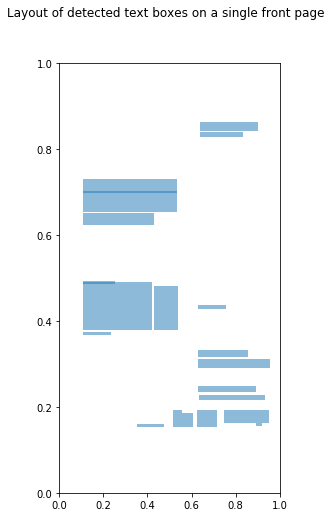

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

plt.figure(figsize=(WIDTH/200, HEIGHT/200))
currentAxis = plt.gca()

for i, row in one_paper.iterrows():
    left = row.bbox_left / row.page_width
    right = row.bbox_right / row.page_width
    top = row.bbox_top / row.page_height
    bottom = row.bbox_bottom / row.page_height
    
    currentAxis.add_patch(Rectangle((left, bottom), right-left, top-bottom,alpha=0.5))
    
plt.suptitle('Layout of detected text boxes on a single front page')
plt.show()

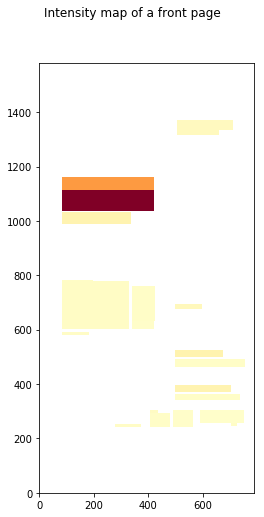

In [41]:
import numpy as np

def make_intensity_grid(paper, height=HEIGHT, width=WIDTH, verbose=False):
    intensity_grid = np.zeros((height, width))

    for i, row in paper.iterrows():
        left = int(row.bbox_left)
        right = int(row.bbox_right)
        top = int(row.bbox_top)
        bottom = int(row.bbox_bottom)

        if np.count_nonzero(intensity_grid[bottom:top, left:right]) > 0:
            if verbose:
                print('Warning: overlapping bounding box with', bottom, top, left, right)
        intensity_grid[bottom:top, left:right] = row.avg_character_area
    
    return intensity_grid

def plot_intensity(intensity, title, scale=100):
    height, width = intensity.shape
    fig = plt.figure(figsize=(height/scale, width/scale))
    ax = plt.gca()

    cmap = plt.get_cmap('YlOrRd')
    cmap.set_under(color='white')

    fig.suptitle(title)
    plt.imshow(intensity, cmap=cmap, extent=[0, width, 0, height], origin='lower', vmin=0.1)
    plt.close()
    return fig
    
intensity_grid = make_intensity_grid(one_paper)
plot_intensity(intensity_grid, 'Intensity map of a front page')

In [11]:
intensities = []
for i, ((date, slug), paper) in enumerate(df_at_size.groupby(['date', 'slug'])):
    if i % 50 == 0:
        print('.', end='')
    intensities.append(make_intensity_grid(paper))

.......

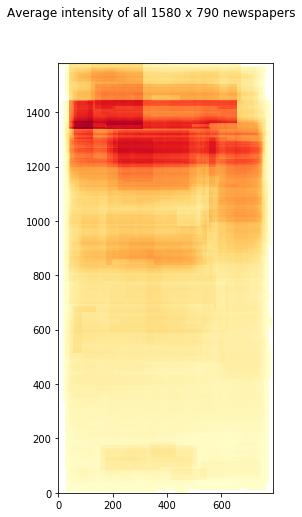

In [12]:
avg_intensity = sum(intensities) / len(intensities)
plot_intensity(avg_intensity, 'Average intensity of all {} x {} newspapers'.format(HEIGHT, WIDTH))

# Considering all newspapers of the same aspect ratio

We had to subset the newspapers quite significantly in order to find a bunch with the same exact height and width. Instead, let's find the newspapers with the same aspect ratio, and consider them after scaling.

In [13]:
df['aspect_ratio'] = df['page_width_round_10'] / df['page_height_round_10']

print('''Out of {} newspapers, there are {} unique aspect ratios.

The top ones are:
{}'''.format(
    df.slug.nunique(),
    df.groupby('slug').aspect_ratio.first().nunique(),
    df.groupby('slug').aspect_ratio.first().value_counts().head(5)
))

Out of 601 newspapers, there are 246 unique aspect ratios.

The top ones are:
0.500000    46
0.523179    30
0.512987    19
0.484663    17
0.493750    12
Name: aspect_ratio, dtype: int64


The top ones all look awfully close to 50-50. Let's round to the tenth place.

In [14]:
import math

df['aspect_ratio'] = np.round(df['page_width_round_10'] / df['page_height_round_10'], decimals=1) 

print('''This time, there are {} unique aspect ratios.

Top ones:
{}'''.format(
    df.groupby('slug').aspect_ratio.first().nunique(),
    df.groupby('slug').aspect_ratio.first().value_counts()
))

This time, there are 9 unique aspect ratios.

Top ones:
0.5    359
0.7    101
0.6     86
0.8     28
0.9     17
0.4      4
1.0      4
1.4      1
1.1      1
Name: aspect_ratio, dtype: int64


Over half of the newspapers have roughly a 1:2 aspect ratio. Let's scale them and push the errors toward the right and bottom margins.

In [15]:
smallest_width = df[df.aspect_ratio == 0.5].page_width_round_10.min()
smallest_height = df[df.aspect_ratio == 0.5].page_height_round_10.min()
print('''The easiest way would be to scale down to the smallest dimensions.

{} x {}'''.format(
    smallest_width,
    smallest_height
))

The easiest way would be to scale down to the smallest dimensions.

680 x 1410


In [16]:
from scipy.misc import imresize

intensities = []
for i, ((date, slug), paper) in enumerate(df[df.aspect_ratio == 0.5].groupby(['date', 'slug'])):
    if i % 50 == 0:
        print('.', end='')
    intensities.append(imresize(make_intensity_grid(paper), (smallest_height, smallest_width)))

....................................................................

In [17]:
count = len(intensities)
avg_intensity = sum([x / count for x in intensities])

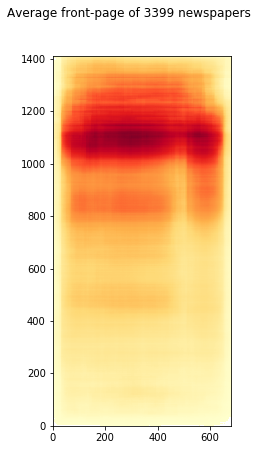

In [18]:
plot_intensity(avg_intensity, 'Average front-page of {} newspapers'.format(len(intensities)))

# Heatmap by newspaper

Each newspaper should have its own distinct appearance. Let's try grouping them by newspaper.

In [36]:
newspapers[newspapers.slug == 'NY_NYT'].head()

,city,country,latitude,longitude,slug,state,title,website
295,New York,USA,40.757053,-73.987267,NY_NYT,NY,The New York Times,http://www.nytimes.com


In [82]:
def newspaper_for_slug(slug):
    return newspapers[newspapers.slug == slug].title.iloc[0]

def slug_for_newspaper(title):
    return newspapers[newspapers.title == title].slug.iloc[0]

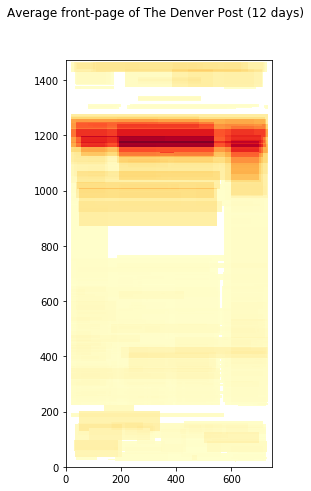

In [135]:
def avg_frontpage_for(newspaper_title='', random=False, paper=df):
    if newspaper_title:
        slug = slug_for_newspaper(newspaper_title)
        if slug not in paper.slug.unique():
            return 'No data'
    elif random:
        slug = paper.sample(1).slug.iloc[0]
        newspaper_title = newspaper_for_slug(slug)
    else:
        raise ArgumentError('Need newspaper_title or random=True')
    
    newspaper = paper[paper.slug == slug]
    width = newspaper.iloc[0].page_width_round
    height = newspaper.iloc[0].page_height_round

    intensities = []
    for i, ((date, slug), paper) in enumerate(newspaper.groupby(['date', 'slug'])):
        intensities.append(make_intensity_grid(paper, height=height, width=width))

    avg_intensity = sum([x / len(intensities) for x in intensities])

    return plot_intensity(avg_intensity, 'Average front-page of {} ({} days)'.format(newspaper_title, newspaper.date.nunique()))

avg_frontpage_for('The Denver Post')

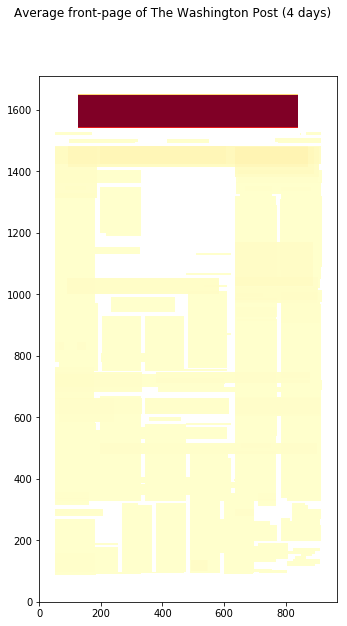

In [88]:
avg_frontpage_for('The Washington Post')

We see the issue here with the title of the newspaper taking up a lot of space.

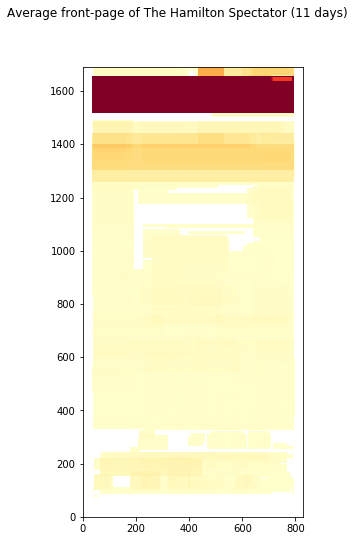

In [89]:
avg_frontpage_for(random=True)

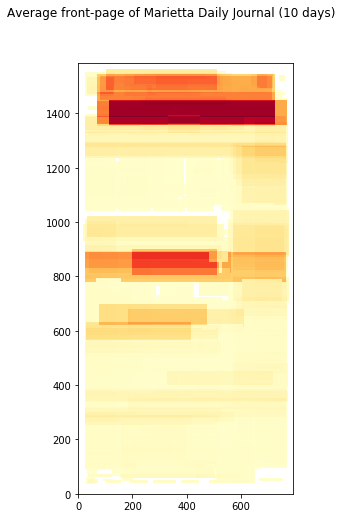

In [99]:
avg_frontpage_for(random=True)

In [102]:
df[df.slug == slug_for_newspaper('Marietta Daily Journal')].text.value_counts().head()

By Mary Kate McGowan\n       13
mkmcgowan@mdjonline.com\n    12
jgargis@mdjonline.com\n      10
Marietta Daily Journal\n     10
A1\n                         10
Name: text, dtype: int64

# Eliminating bylines, newspaper names, etc.

There are lots of repetitive non-article text that we want to eliminate. The heuristic we'll use is whether they appear more than once.

In [126]:
text_counts = df.groupby(['slug']).text.value_counts()

duplicate_text = text_counts[text_counts > 1].reset_index(name='count').drop('count', axis=1)

print('Detected {} rows of duplicate text'.format(duplicate_text.shape[0]))

Detected 20457 rows of duplicate text


In [132]:
from collections import defaultdict

duplicate_text_dict = defaultdict(set)
_ = duplicate_text.apply(lambda row: duplicate_text_dict[row.slug].add(row.text), axis=1)

In [142]:
df_clean = df[df.apply(lambda row: row.text not in duplicate_text_dict[row.slug], axis=1)]

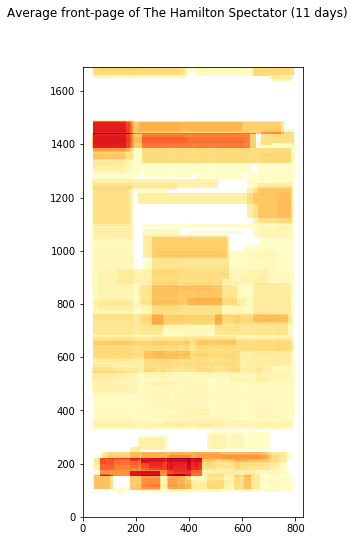

In [143]:
avg_frontpage_for('The Hamilton Spectator', paper=df_clean)

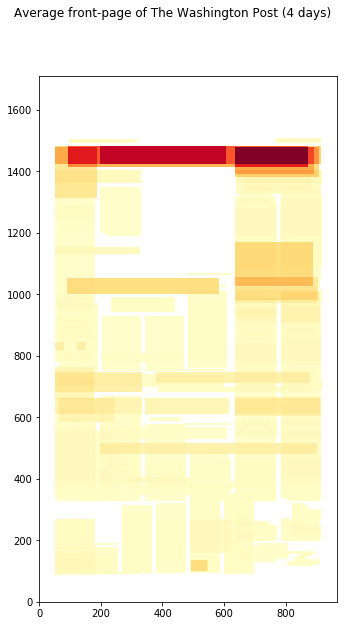

In [144]:
avg_frontpage_for('The Washington Post', paper=df_clean)

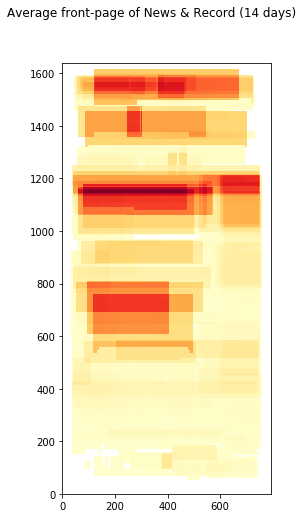

In [157]:
avg_frontpage_for(random=True, paper=df_clean)

# Average front page, with cleaned text

....................................................................

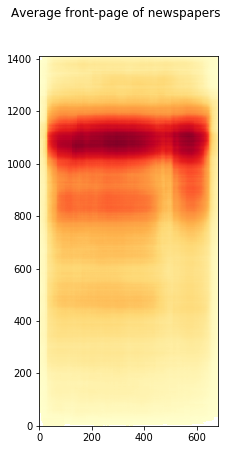

In [145]:
intensities = []
for i, ((date, slug), paper) in enumerate(df_clean[df_clean.aspect_ratio == 0.5].groupby(['date', 'slug'])):
    if i % 50 == 0:
        print('.', end='')
    intensities.append(imresize(make_intensity_grid(paper), (smallest_height, smallest_width)))

count = len(intensities)
avg_intensity = sum([x / count for x in intensities])

plot_intensity(avg_intensity, 'Average front-page of newspapers')